In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 1000
svg_renderer.height = 1000
pio.renderers.default = "svg"

Using TensorFlow backend.


## LSTM

In [5]:
def normalize2(series, _min, _max, _mean):
    return list(map(lambda x: (x - _mean) / (_max - _min), series))

def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm


def denormalize(test_y, df, predict_target="3_day_return"):
    return test_y * (np.max(df[predict_target]) - np.min(df[predict_target])) + np.mean(
        df[predict_target]
    )


def train_(df, ref_day=5, predict_day=1, predict_target="3_day_return"):
    X_train, Y_train = [], []
    for i in range(df.shape[0] - predict_day - ref_day):
        X_train.append(np.array(df.iloc[i : i + ref_day, df.columns != predict_target]))
        Y_train.append(
            np.array(df.iloc[i + ref_day : i + ref_day + predict_day][predict_target])
        )
    return np.array(X_train), np.array(Y_train)


def get_train_test(X, Y, split_boundary):
    train_x = X[:split_boundary]
    test_x = X[split_boundary:]
    train_y = Y[:split_boundary]
    test_y = Y[split_boundary:]
    return train_x, test_x, train_y, test_y


def get_model(train_x):
    model = Sequential()
    model.add(
        LSTM(
            units=30,
            return_sequences=True,
            input_shape=(train_x.shape[1], train_x.shape[2]),
        )
    )
    model.add(Dropout(0.5))
    model.add(LSTM(units=30))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

    return model


def train(df, title=None, split_boundary=2110, predict_target="3_day_return"):

    norm_df = normalize(df)

    # 7 days predict 1 day
    X, Y = train_(norm_df, 7, 1, predict_target)
    train_x, test_x, train_y, test_y = get_train_test(X, Y, split_boundary)

    model = get_model(train_x)
    es = EarlyStopping(monitor="loss", patience=100, verbose=0, mode="min")
    history = model.fit(
        train_x, train_y, epochs=1000, batch_size=128, verbose=0, callbacks=[es]
    )
#     fig = make_subplots(rows=1, cols=1)
#     fig.add_trace(
#         go.Scatter(y=history.history["loss"], name="training loss"), row=1, col=1
#     )

    score = model.evaluate(test_x, test_y, verbose=0)
    predict_y = model.predict(test_x)
    
    ## calculate predict mse
    test_y_list = denormalize(test_y, df, predict_target).ravel()
    predict_y_list = denormalize(predict_y, df, predict_target).ravel()
    origina_min = np.min(test_y_list)
    origina_max = np.max(test_y_list)
    origina_mean = np.mean(test_y_list)
    norm_mse = mean_squared_error(
        normalize2(test_y_list, origina_min, origina_max, origina_mean), 
        normalize2(predict_y_list, origina_min, origina_max, origina_mean), 
    )
    
    mean = np.mean(np.abs(np.array(predict_y_list) - np.array(test_y_list)))

#     fig.add_trace(
#         go.Scatter(y=test_y_list, mode="lines", name="actual return"), row=2, col=1
#     )
#     fig.add_trace(
#         go.Scatter(y=predict_y_list, mode="lines", name="predict return"), row=2, col=1
#     )
#     fig.update_layout(
#         title_text="Crops : {}, Loss : {}, Mean: {}".format(title, score[0], mean),
#     )
#     fig.show()
    print("Crops : {}, MSE: {}, Mean : {}".format(title, norm_mse, mean))
    return test_y_list, predict_y_list, norm_mse, mean 


crops_arr = [
    "香蕉",
    "洋香瓜-網狀紅肉",
    "蓮霧-紅蓮霧",
    "鳳梨-金鑽鳳梨",
    "南瓜-木瓜形",
    "大蒜-蒜仁",
    "青蔥-日蔥",
    "小白菜-土白菜",
    "芽菜類-黃豆牙",
    "木瓜-網室紅肉",
]


## Predict without feature selection

### Price

In [3]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    test_y_list, predict_y_list, norm_mse, mean_diff = train(
        df.drop(columns=["DateTime", "Year", "Day"]),
        crops,
        split_boundary - 8,
        "平均價",
    )
    data = {
        "DateTime": df["DateTime"][split_boundary:],
        "Original": test_y_list,
        "Predict": predict_y_list,
        "MSE": norm_mse,
        "Mean": mean_diff
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_Price.csv".format(crops), index=False, encoding="utf_8_sig")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Crops : 香蕉, MSE: 0.2464608201139263, Mean : 8.475406256328059
Crops : 洋香瓜-網狀紅肉, MSE: 0.023040731167964894, Mean : 7.1639495914485165
Crops : 蓮霧-紅蓮霧, MSE: 0.05666960043560234, Mean : 27.31226293064604
Crops : 鳳梨-金鑽鳳梨, MSE: 0.0413850407165789, Mean : 5.6572913651482315
Crops : 南瓜-木瓜形, MSE: 0.051970833464746534, Mean : 5.10056958214495
Crops : 大蒜-蒜仁, MSE: 0.4738804968918785, Mean : 32.88576631482016
Crops : 青蔥-日蔥, MSE: 0.09202762553845005, Mean : 69.90640845665565
Crops : 小白菜-土白菜, MSE: 0.05828891716499817, Mean : 9.83242093280805
Crops : 芽菜類-黃豆牙, MSE: 0.13561599306465033, Mean : 0.3414627563271053
Crops : 木瓜-網室紅肉, MSE: 0.05643052269019355, Mean : 6.843741209610649


### 3 days return

In [5]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    test_y_list, predict_y_list, norm_mse, mean_diff = train(
        df.drop(columns=["DateTime", "Year", "Day"]),
        crops,
        split_boundary - 8,
        "3_day_return",
    )
    data = {
        "DateTime": df["DateTime"][split_boundary:],
        "Original": test_y_list,
        "Predict": predict_y_list,
        "MSE": norm_mse,
        "Mean": mean_diff
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_3_day_return.csv".format(crops), index=False, encoding="utf_8_sig")

Crops : 香蕉, MSE: 0.027339403319294873, Mean : 8.34863879068711
Crops : 洋香瓜-網狀紅肉, MSE: 0.027296942196250947, Mean : 18.383188392399603
Crops : 蓮霧-紅蓮霧, MSE: 0.02084959141555648, Mean : 12.784327746854634
Crops : 鳳梨-金鑽鳳梨, MSE: 0.031024910788461525, Mean : 14.49804260656626
Crops : 南瓜-木瓜形, MSE: 0.01232091878406715, Mean : 10.356569290017987
Crops : 大蒜-蒜仁, MSE: 0.008471797861944023, Mean : 2.075034710456066
Crops : 青蔥-日蔥, MSE: 0.021066161364582923, Mean : 17.440932294578616
Crops : 小白菜-土白菜, MSE: 0.01593503381703509, Mean : 17.91805472674692
Crops : 芽菜類-黃豆牙, MSE: 0.09240104033497414, Mean : 1.8102878702986847
Crops : 木瓜-網室紅肉, MSE: 0.018423174212093607, Mean : 16.27961294133684


## Predict with feature selection
### select top 10 features of each input ( total 7 days input ) and np.unique

In [2]:
import shap

shap.initjs()

def get_important_feature(df, split_boundary, predict_target="3_day_return"):
    norm_df = normalize(df)
    X, Y = train_(norm_df, 7, 1, predict_target)
    train_x, test_x, train_y, test_y = get_train_test(X, Y, split_boundary)

    model = get_model(train_x)
    explainer = shap.GradientExplainer(model, train_x)
    shap_values = explainer.shap_values(test_x)

    feature_index_arr = []

    for i in range(7):
        feature_index_arr.append(
            np.flip(np.argsort(np.abs(shap_values[0]).mean(0))[i])[0:20]
        )
    feature_index = np.unique(feature_index_arr)
    
    # check predict_target in df
    if list(df.columns).index(predict_target) not in feature_index:
        feature_index = np.concatenate([[list(df.columns).index(predict_target)], feature_index])

    return df.iloc[:, feature_index]


### Price

In [7]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    DateTime_arr = df["DateTime"][split_boundary:]
    df = df.drop(columns=["DateTime", "Year", "Day"])
    df = get_important_feature(df, split_boundary - 8, "平均價")
    print("feature selection :", df.columns)
    test_y_list, predict_y_list, norm_mse, mean_diff = train(df, crops, split_boundary - 8, "平均價")
    data = {
        "DateTime": DateTime_arr,
        "Original": test_y_list,
        "Predict": predict_y_list,
        "MSE": norm_mse,
        "Mean": mean_diff
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_Price_fs.csv".format(crops), index=False, encoding="utf_8_sig")


feature selection : Index(['Month', '平均價', '5_day_return', 'C0A530_StnPres', 'C0A530_Precp',
       '467490_StnPres', '467490_Temperature', '467420_Precp',
       '467440_StnPres', 'C0C590_StnPres', 'C0C590_Precp',
       'C0D560_Temperature', 'C0D560_WS', 'C0E750_Temperature', 'C0E750_Precp',
       'C0H950_Temperature', 'C0G660_StnPres', 'C0G660_WS', 'C0G660_Precp',
       'C0K240_StnPres', '467480_StnPres', '467480_WS', '467480_Precp',
       '467590_StnPres', '467590_Temperature', '467590_Precp',
       'C0Z061_Temperature', 'C0Z061_Precp', '467660_StnPres'],
      dtype='object')
Crops : 香蕉, MSE: 0.09298743799291416, Mean : 5.870559626040252
feature selection : Index(['平均價', 'Month', '5_day_return', 'C0A530_StnPres', 'C0A530_WS',
       'C0A530_Precp', '467490_StnPres', '467420_StnPres', 'C0C590_WS',
       'C0C590_Precp', 'C0D560_StnPres', 'C0D560_Temperature',
       'C0E750_StnPres', 'C0E750_Temperature', 'C0E750_Precp',
       'C0H950_StnPres', 'C0G660_StnPres', 'C0G660_Tempe

### 3 days return

In [8]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    DateTime_arr = df["DateTime"][split_boundary:]
    df = df.drop(columns=["DateTime", "Year", "Day"])
    df = get_important_feature(df, split_boundary - 8, "3_day_return")
    print("feature selection :", df.columns)
    test_y_list, predict_y_list, norm_mse, mean_diff = train(df, crops, split_boundary - 8, "3_day_return")
    data = {
        "DateTime": DateTime_arr,
        "Original": test_y_list,
        "Predict": predict_y_list,
        "MSE": norm_mse,
        "Mean": mean_diff
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_3_day_return_fs.csv".format(crops), index=False, encoding="utf_8_sig")

feature selection : Index(['3_day_return', 'Month', '平均價', '5_day_return', '強度', 'C0A530_StnPres',
       'C0A530_WS', 'C0A530_Precp', '467420_StnPres', '467440_StnPres',
       '467440_WS', 'C0D560_Temperature', 'C0E750_StnPres',
       'C0E750_Temperature', 'C0E750_Precp', 'C0H950_Temperature',
       'C0H950_Precp', 'C0G660_Temperature', 'C0G660_WS', 'C0G660_Precp',
       'C0K240_WS', '467480_Temperature', '467590_Temperature', '467590_Precp',
       '467660_StnPres', '467660_WS'],
      dtype='object')
Crops : 香蕉, MSE: 0.016689450142945213, Mean : 6.371856589359789
feature selection : Index(['3_day_return', 'Month', 'C0A530_StnPres', 'C0A530_Temperature',
       'C0A530_Precp', '467490_StnPres', '467420_Precp', '467440_Temperature',
       'C0C590_Temperature', 'C0D560_StnPres', 'C0D560_WS', 'C0D560_Precp',
       'C0E750_StnPres', 'C0E750_Temperature', 'C0E750_WS', 'C0H950_Precp',
       'C0G660_StnPres', 'C0G660_WS', 'C0K240_StnPres', 'C0K240_Precp',
       '467480_StnPres', '46

## Plot line chart

In [19]:
def plot_chart_all(crops):
    csv_arr = ["Price", "Price_fs", "3_day_return", "3_day_return_fs"]
    fig = make_subplots(
        rows=4, cols=1,
        subplot_titles=csv_arr
    )
   
    for i in range(4):
        df = pd.read_csv("./512/{}_{}.csv".format(crops, csv_arr[i]))
        print("{}_{}, MSE : {}, Mean : {}".format(crops, csv_arr[i], df['MSE'][0], df['Mean'][0]))
        fig.add_trace(
            go.Scatter(
                x=df["DateTime"],
                y=df["Original"],
                mode="lines",
                name="Original return",
                line=dict(color="royalblue"),
            ),
            row=i + 1,
            col=1,
        )
        fig.add_trace(
            go.Scatter(
                x=df["DateTime"],
                y=df["Predict"],
                mode="lines",
                name="Predict return",
                line=dict(color="red"),
            ),
            row=i + 1,
            col=1,
        )
    fig.update_layout(height=2000, title_text=crops)
    fig.show()


香蕉_Price, MSE : 0.30144008207586137, Mean : 9.834448154156023
香蕉_Price_fs, MSE : 0.1583770600792171, Mean : 6.508441340723963
香蕉_3_day_return, MSE : 0.017154489526922403, Mean : 6.308662096697817
香蕉_3_day_return_fs, MSE : 0.012671568865499307, Mean : 5.512934659666129


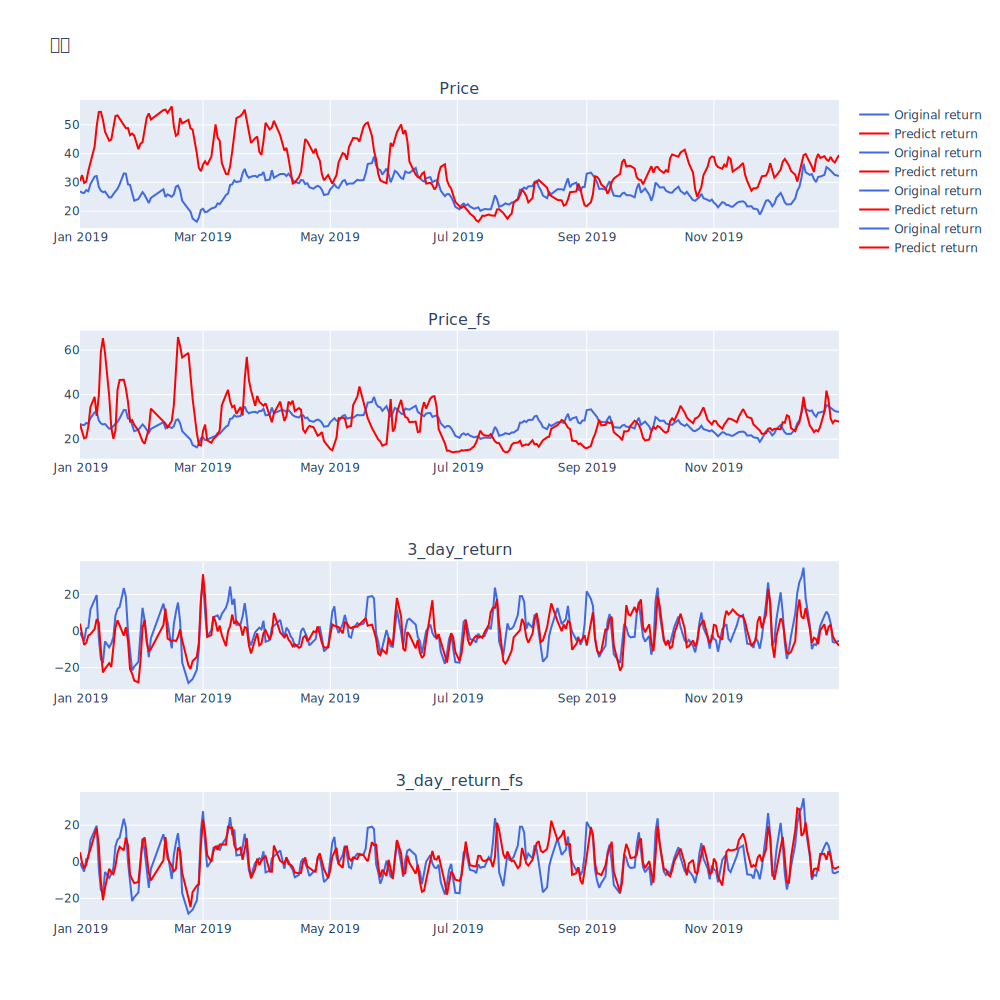

洋香瓜-網狀紅肉_Price, MSE : 0.01965525653397061, Mean : 6.965998480920078
洋香瓜-網狀紅肉_Price_fs, MSE : 0.017473899965878576, Mean : 6.602311915443058
洋香瓜-網狀紅肉_3_day_return, MSE : 0.015058339494917668, Mean : 13.625970751730256
洋香瓜-網狀紅肉_3_day_return_fs, MSE : 0.03840981630492138, Mean : 19.62480524882648


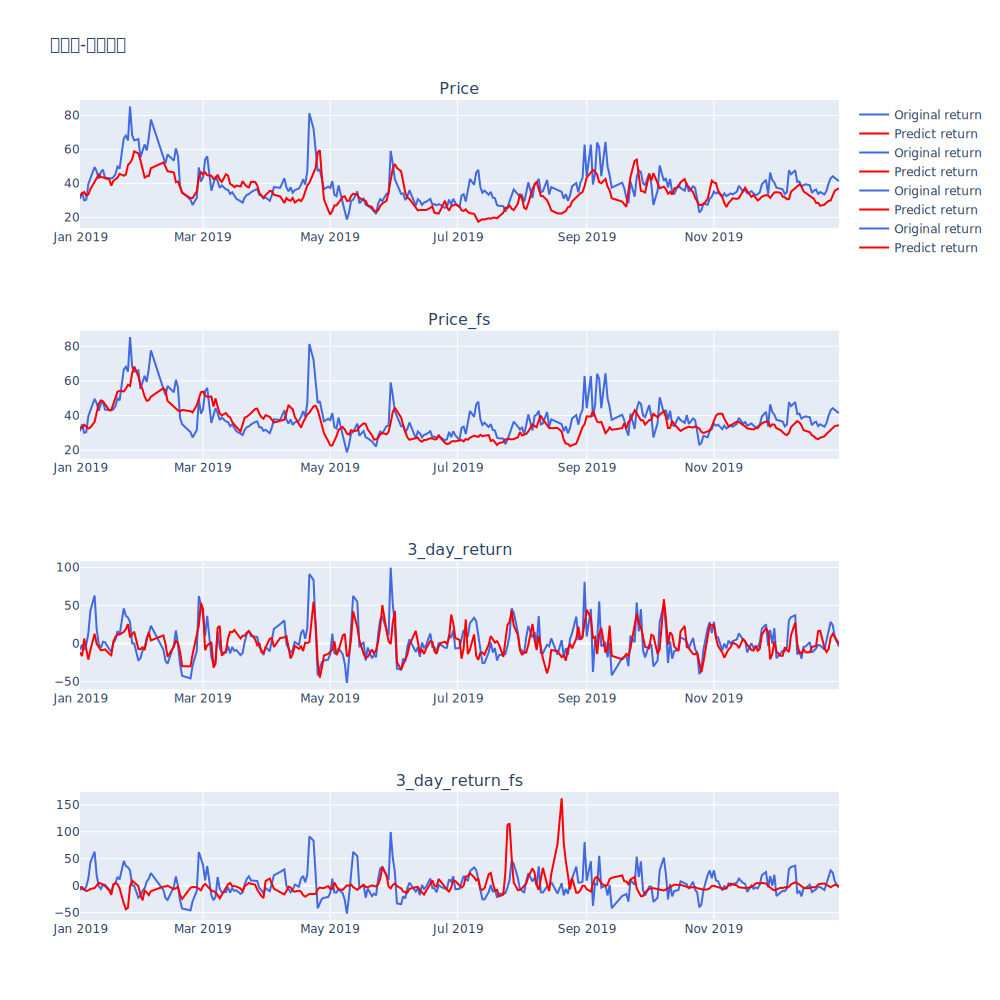

蓮霧-紅蓮霧_Price, MSE : 0.028388210612416306, Mean : 18.55576186980177
蓮霧-紅蓮霧_Price_fs, MSE : 0.018065918943787968, Mean : 14.423805431391571
蓮霧-紅蓮霧_3_day_return, MSE : 0.013927553013025527, Mean : 10.686452900349607
蓮霧-紅蓮霧_3_day_return_fs, MSE : 0.014596212437435885, Mean : 10.793208228135367


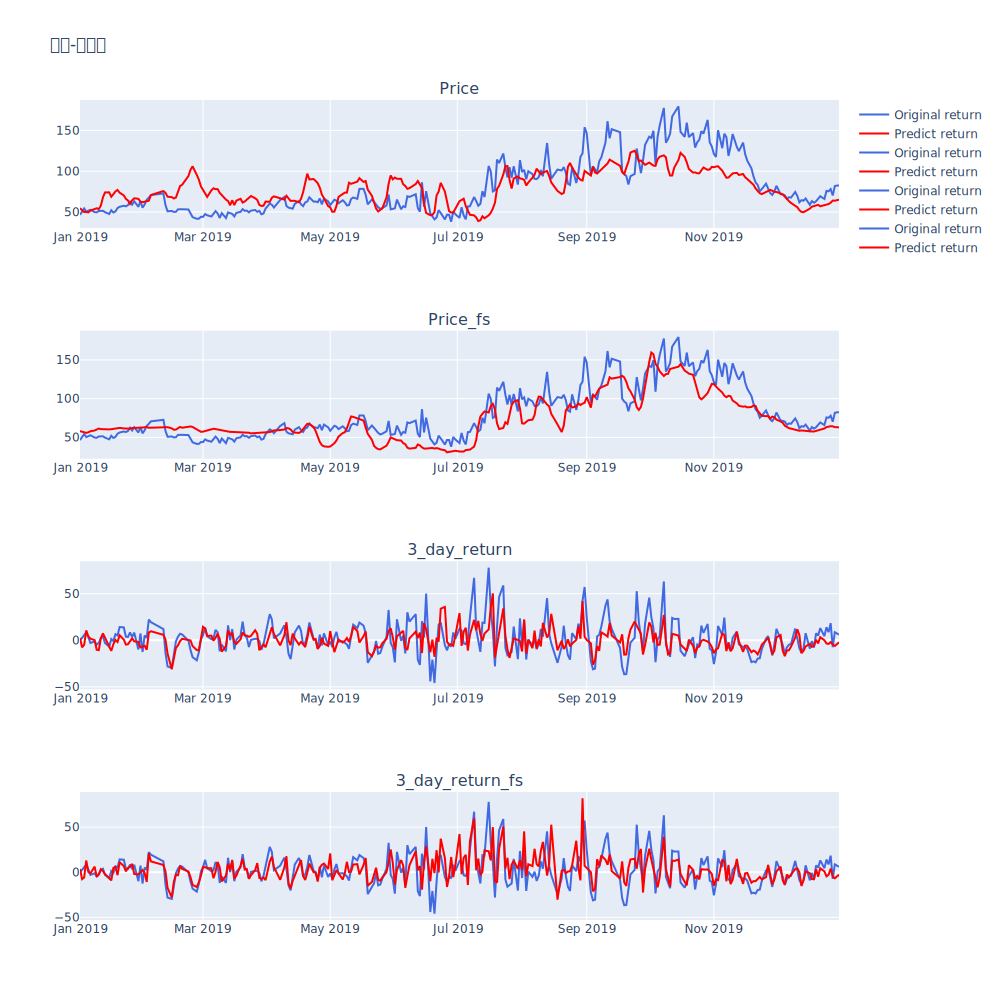

鳳梨-金鑽鳳梨_Price, MSE : 0.032180925378483334, Mean : 4.832762363523145
鳳梨-金鑽鳳梨_Price_fs, MSE : 0.04928363859897319, Mean : 6.049408908193326
鳳梨-金鑽鳳梨_3_day_return, MSE : 0.016177307061521127, Mean : 10.16071599072832
鳳梨-金鑽鳳梨_3_day_return_fs, MSE : 0.00791872718231436, Mean : 6.736838992348727


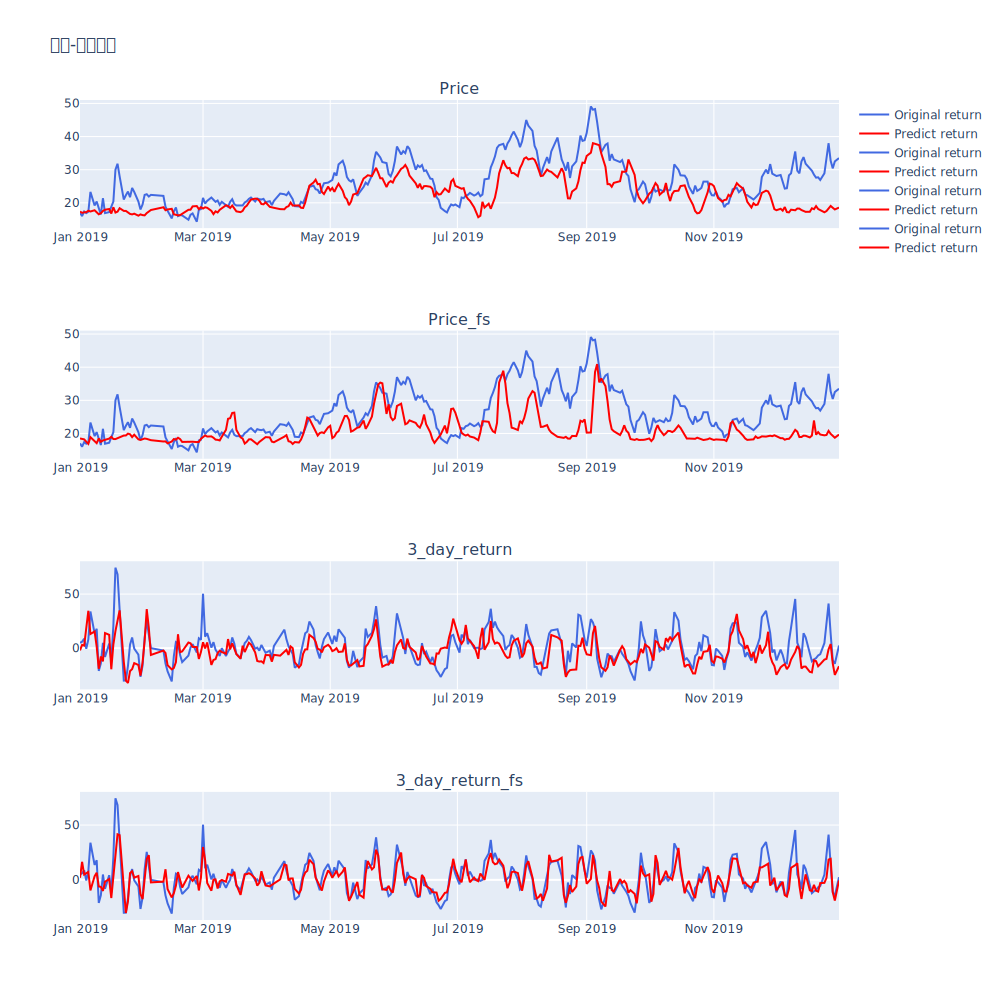

南瓜-木瓜形_Price, MSE : 0.14046887204756456, Mean : 7.860964976664769
南瓜-木瓜形_Price_fs, MSE : 0.058072322788358964, Mean : 5.098712314490888
南瓜-木瓜形_3_day_return, MSE : 0.008114438098337938, Mean : 8.117926183799979
南瓜-木瓜形_3_day_return_fs, MSE : 0.00791877833234095, Mean : 7.821863286296871


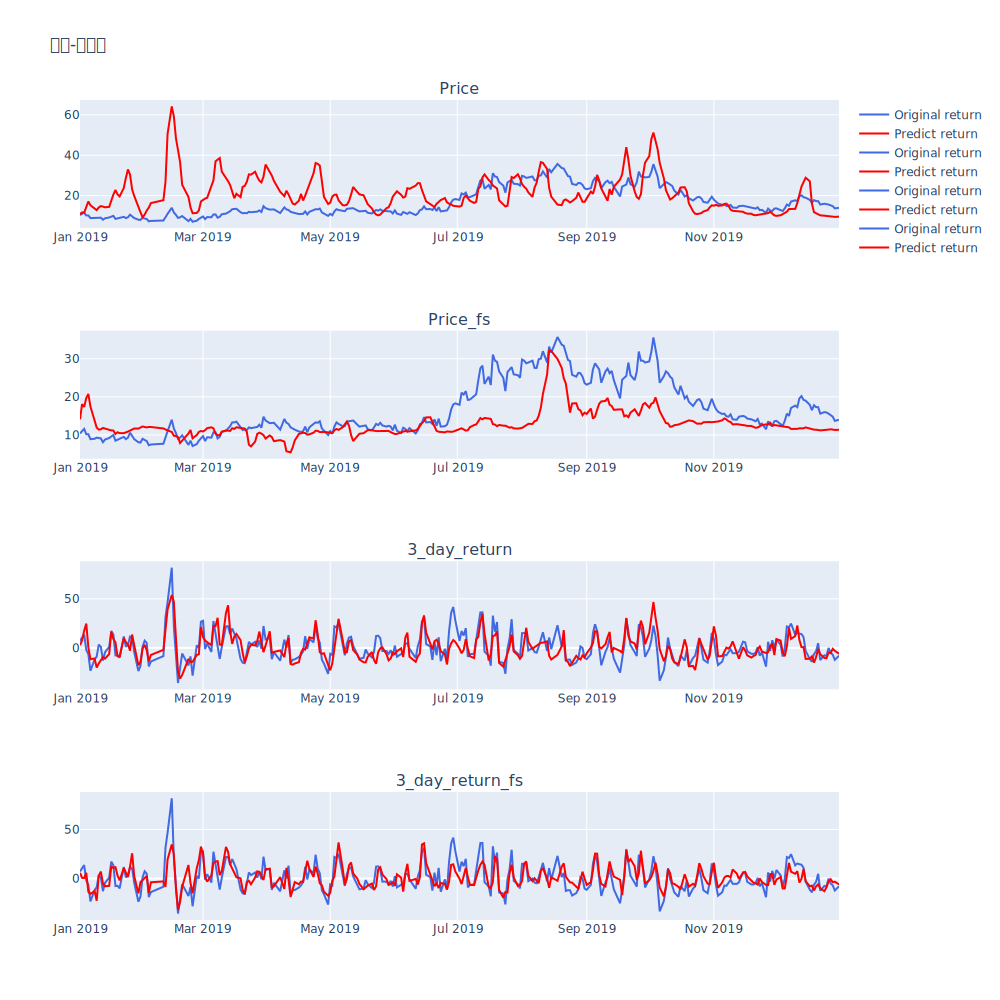

大蒜-蒜仁_Price, MSE : 0.5595168680257256, Mean : 36.539966660057935
大蒜-蒜仁_Price_fs, MSE : 0.503400939358417, Mean : 35.920611764280586
大蒜-蒜仁_3_day_return, MSE : 0.00717175576235715, Mean : 1.857918154882824
大蒜-蒜仁_3_day_return_fs, MSE : 0.006322154178934428, Mean : 1.5998058945627924


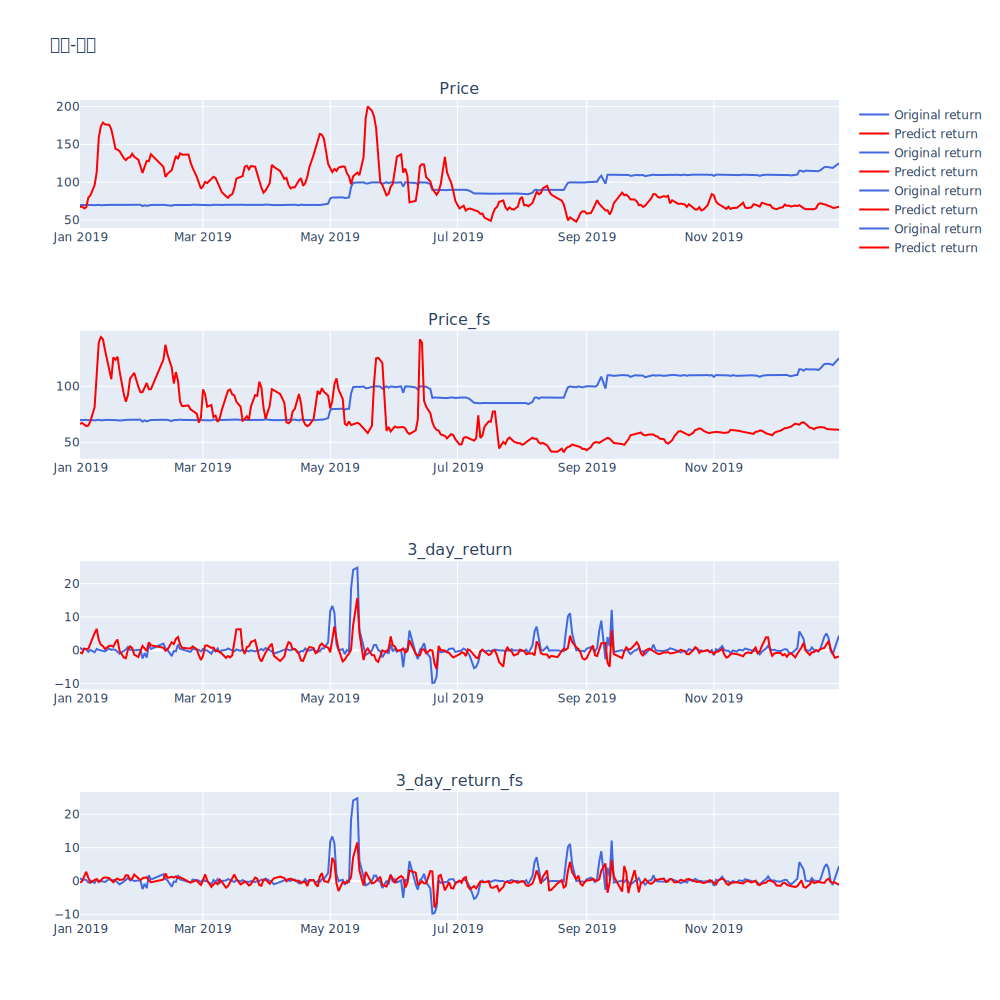

青蔥-日蔥_Price, MSE : 0.08757476337422716, Mean : 70.36561987631296
青蔥-日蔥_Price_fs, MSE : 0.09406192254219696, Mean : 79.6004531350024
青蔥-日蔥_3_day_return, MSE : 0.011367490939490372, Mean : 12.828528583743074
青蔥-日蔥_3_day_return_fs, MSE : 0.01049089528490002, Mean : 12.616638657104847


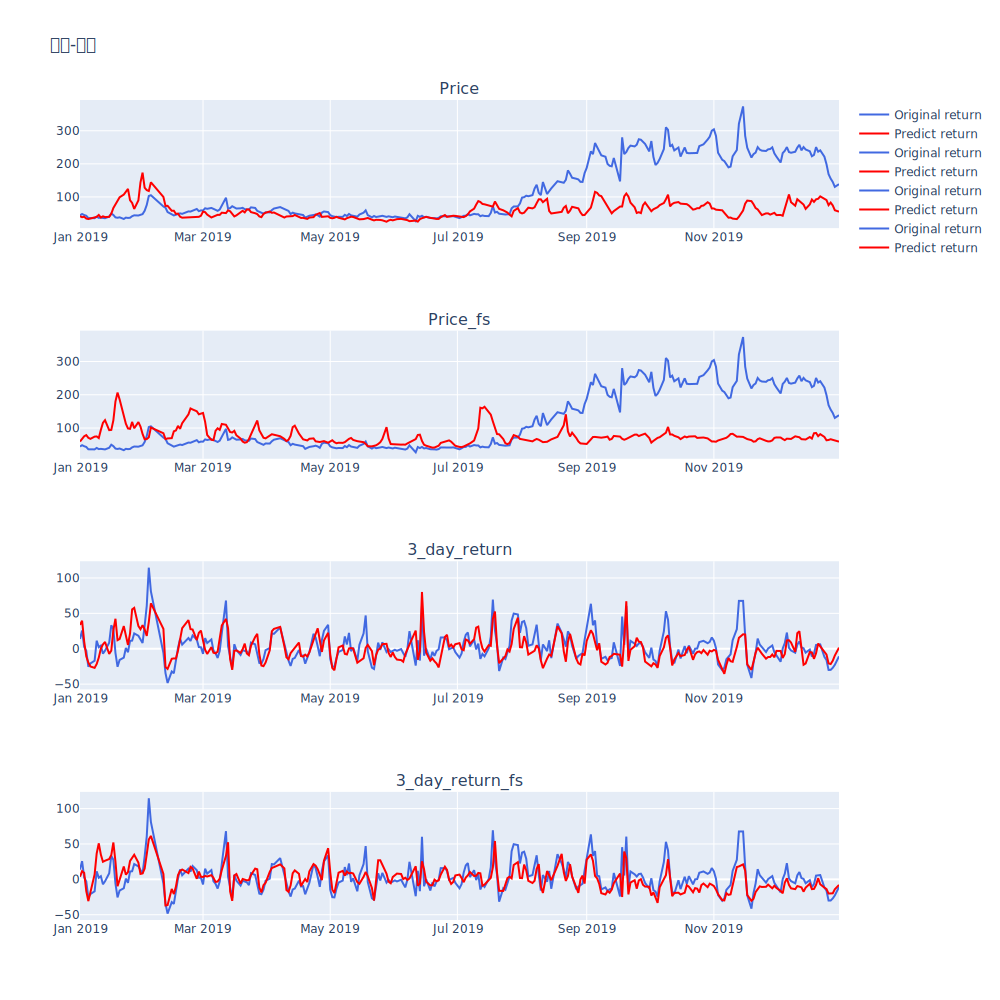

小白菜-土白菜_Price, MSE : 0.05028427359605503, Mean : 9.275091131714275
小白菜-土白菜_Price_fs, MSE : 0.041798406649830866, Mean : 8.033799135086927
小白菜-土白菜_3_day_return, MSE : 0.01324896555351166, Mean : 15.946554771370812
小白菜-土白菜_3_day_return_fs, MSE : 0.01443313911983467, Mean : 15.427531330826113


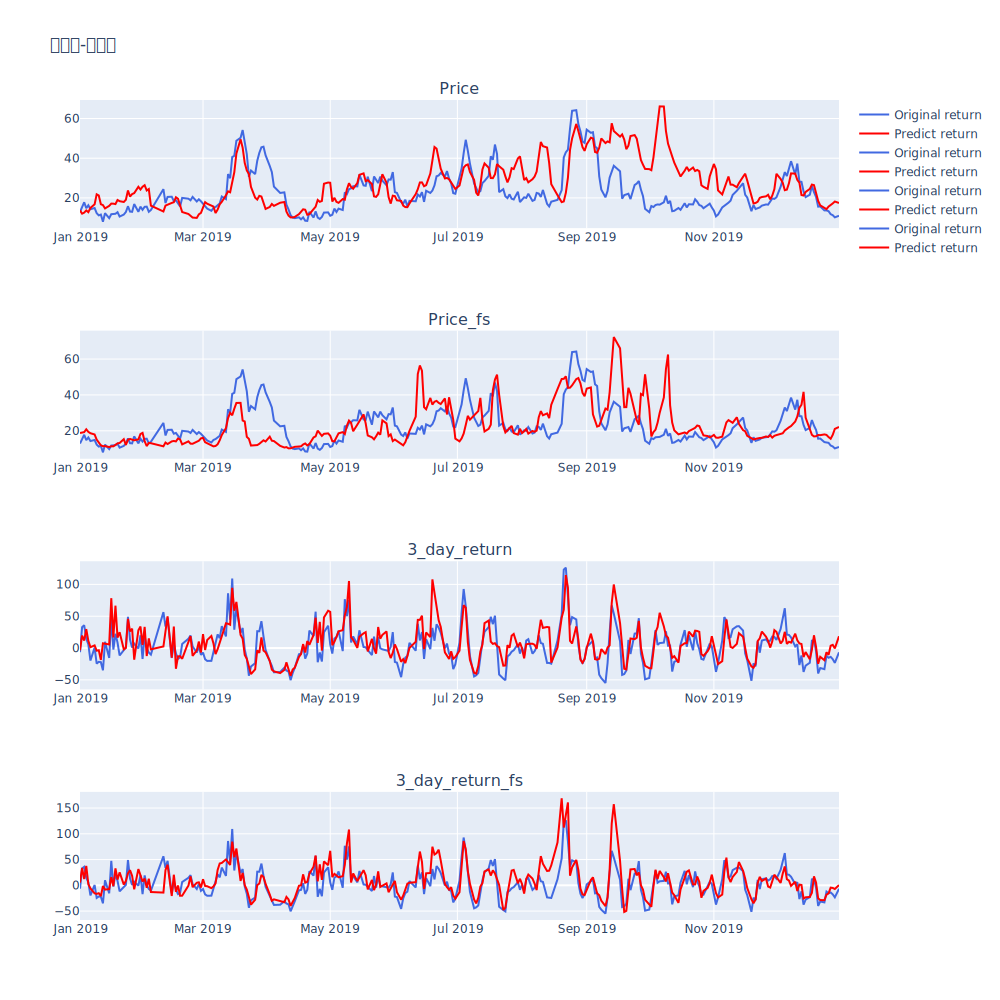

芽菜類-黃豆牙_Price, MSE : 0.05705190300323479, Mean : 0.23778912065807756
芽菜類-黃豆牙_Price_fs, MSE : 0.34435363161306953, Mean : 0.7072985421126127
芽菜類-黃豆牙_3_day_return, MSE : 0.059969680941931225, Mean : 1.4191359779789667
芽菜類-黃豆牙_3_day_return_fs, MSE : 0.009581330102769531, Mean : 0.5130705977198149


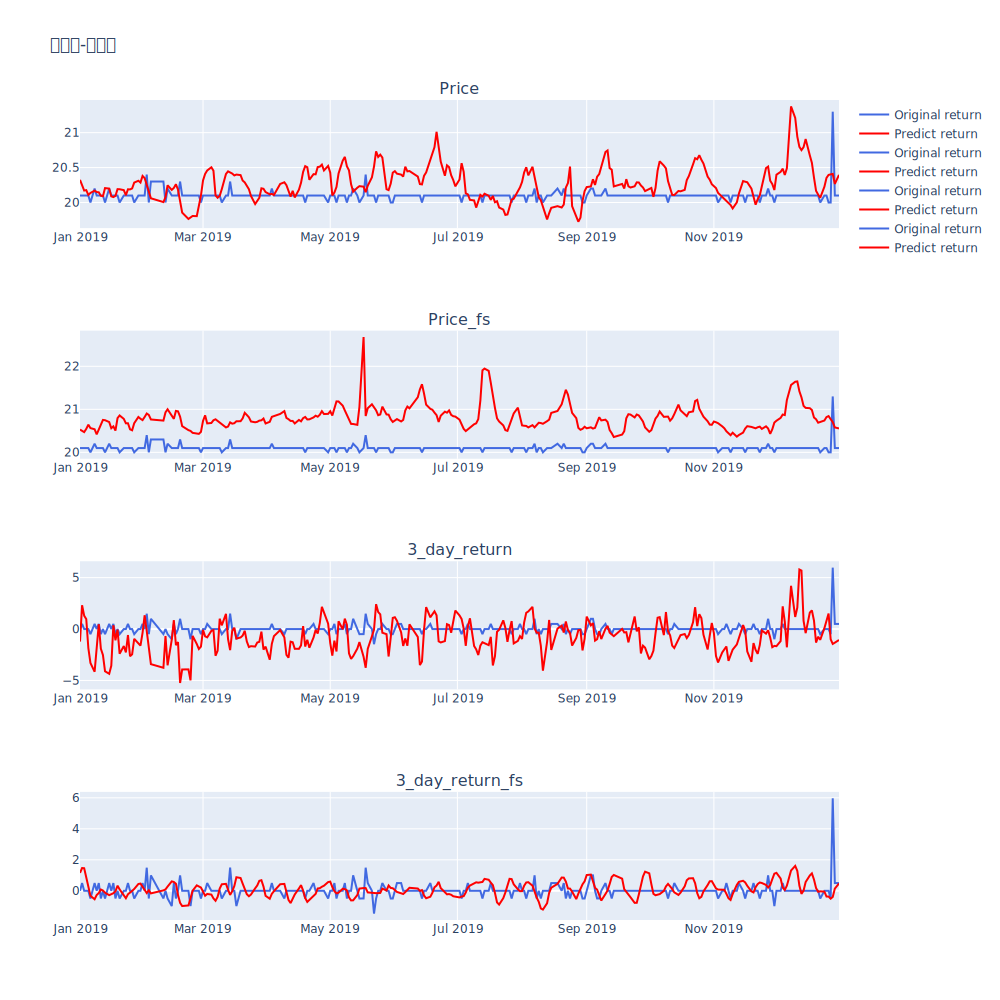

木瓜-網室紅肉_Price, MSE : 0.048476910139628064, Mean : 6.447368956090614
木瓜-網室紅肉_Price_fs, MSE : 0.08618934544161877, Mean : 8.992605636749778
木瓜-網室紅肉_3_day_return, MSE : 0.008468892817715174, Mean : 10.822484677351255
木瓜-網室紅肉_3_day_return_fs, MSE : 0.024626944093029204, Mean : 17.561444821432133


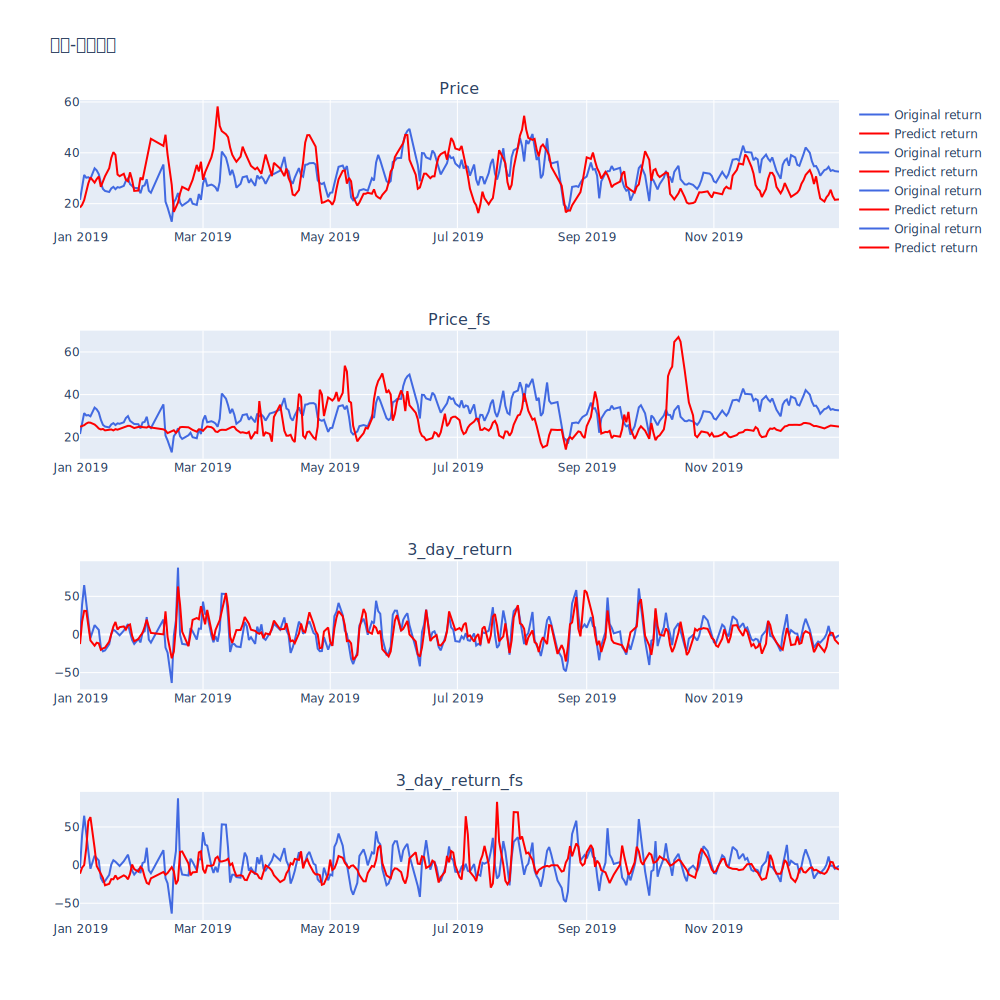

In [20]:
for crops in crops_arr:
    plot_chart_all(crops)